In [1]:
import sys, os
import numpy as np
import json
import matplotlib.pyplot as plt

from parser_bookshelf import Parser
from placedb import ChipInfo
from placer import Placer
from util import bcolors, ArgxParser

### Parameters

In [2]:
def parse_cfg(cfg_file):
    cfg = {}
    with open(cfg_file) as json_f:
        cfg = json.load(json_f)
        cfg['cfg_file'] = cfg_file
    return cfg

### Parse Case

In [3]:
## Parse config file and args
cfg = parse_cfg("../test/toy0.config")

## Parse bookshelf file
parser = Parser(cfg['aux'])
parser.parse_bookshelf(print_info=False)

## Construct ChipInfo
chip_info = ChipInfo(cfg)
chip_info.set_from_parser(parser)
chip_info.print_info()

[Placedb] - case_name:      toy0
[Placedb] - board_size:     (32, 32)
[Placedb] - board_llxy:     (0, 0)
[Placedb] - num_bins:       32
[Placedb] - bin_size:       (1.0, 1.0)
[Placedb] - target_density: 1.02
[Placedb] - #module:        16
[Placedb] - #movable:       6
[Placedb] - #std-cell:      3
[Placedb] - #macro:         3
[Placedb] - #pad:           10
[Placedb] - #net:           5
[Placedb] - Util (%):       2.87


In [4]:
## Init Placer
placer = Placer(chip_info, chip_info.netlist, gamma=cfg['GAMMA'], target_density=cfg['target_density'], weight_increase_factor=cfg['WeightIncreaseFactor'], trunc_factor=cfg['TRUNC_FACTOR'])

### Initialize Density Model

PBIN: Zero space bin #= 443 (43.26171875%).  Algorithm utilization= 0.04603022599026849


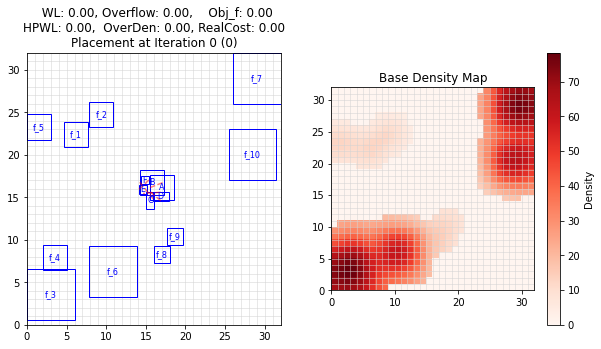

In [5]:
# Initialize random positions for cells (2D positions: x, y)
np.random.seed(cfg['seed'])  # For reproducibility
init_pos = placer.initialize_placement() if chip_info.netlist.cells_pos.all() == 0 else chip_info.netlist.cells_pos.copy()
placer.set_pos(init_pos)
# Initialize bins expected potential
placer.init_density_model(show_info=True)
# Visualization Check 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
costs_info = {"total_hpwl": 0, "total_lse": 0, "total_density_overflow": 0, "total_potential_overflow": 0, "total_obj_value": 0, "total_cost": 0, "weight_density": 0, "gWL": 1, "gPot": 0}
density_map = np.maximum(placer.bins_potential.detach().cpu().numpy() - placer.bins_expect_potential.detach().cpu().numpy(), 0)
placer.plot_placement(axs[0], 0, 0, costs_info)
placer.plot_density_map(fig, axs[1], "Base Density Map", density_map, _vmax=None)

### Analytical Placement with CG (gradient-based)

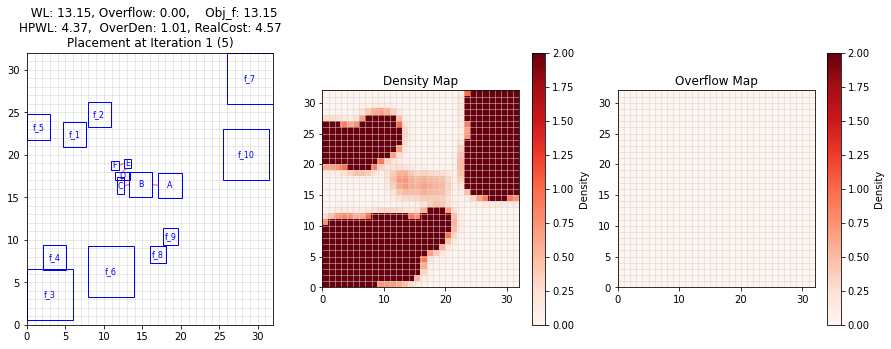

In [6]:
step_size = min(chip_info.board_size) / chip_info.num_bins
cg_loss_list = []
cost_info_list = []
bPlot = True
# init
placer.reset_frames()
early_stop = False
not_efficient = False
placer.set_pos(init_pos)
weight_density = placer.init_weight_density()
total_lse = placer.calculate_lse_wl()
total_hpwl = placer.calculate_hpwl()
total_density_overflow, _, max_den = placer.calculate_overflow_density()
total_potential_overflow, _, _ = placer.calculate_overflow_potential()
grad_wl = placer.calculate_wl_gradient(); grad_pot = placer.calculate_density_gradient()
wl_pot_balance_ratio = total_lse / total_potential_overflow
total_obj_value = placer.calculate_obj_value(total_lse, total_potential_overflow, weight_density * wl_pot_balance_ratio)
cost_info = {"total_hpwl": total_hpwl, "total_lse": total_lse.item(), "total_density_overflow": total_density_overflow, "total_potential_overflow": total_potential_overflow.item(), "total_obj_value": total_obj_value.item(), "weight_density": weight_density.item(), "gWL": np.sum(np.abs(grad_wl.detach().cpu().numpy())), "gPot": np.sum(np.abs(grad_pot.detach().cpu().numpy())), "max_den": max_den, "wl_pot_balance_ratio": wl_pot_balance_ratio.item()}
cost_info_list.append([cost_info])

for iter in range(cfg['MAX_ITER']):
    # Update last values
    total_over_den_prev = total_density_overflow
    max_den_prev = max_den
    ############################## Solve sub placement problem with current density weight ##############################################
    cost_info, losses, _ = placer.solve_placement(iter, step_size=step_size, min_inner_iter=cfg['min_inner_iter'], max_inner_iter=cfg['max_inner_iter'], bPlot=bPlot, bSaveFrames=True)
    cg_loss_list.extend(losses)
    cost_info_list.append(cost_info)
    total_density_overflow = cost_info[-1]["total_density_overflow"]; total_lse = cost_info[-1]["total_lse"]; total_potential_overflow = cost_info[-1]["total_potential_overflow"]; total_obj_value = cost_info[-1]["total_obj_value"]; max_den = cost_info[-1]["max_den"]; total_hpwl = cost_info[-1]["total_hpwl"]
    #####################################################################################################################################
    # Check early stop
    enoughIter = iter >= cfg['ENOUGH_ITER']
    spreadEnough = total_density_overflow <= cfg['target_density'] + cfg['SpreadEnoughMoreDen']
    increaseOverDen = total_density_overflow >= total_over_den_prev - 1e-4
    increaseMaxDen = max_den >= max_den_prev - 1e-4
    notEfficientOptimize = 0.5 * total_potential_overflow * weight_density / total_obj_value * 100.0 > 95
    if enoughIter and notEfficientOptimize:
        not_efficient = True
        early_stop = True
    if enoughIter and spreadEnough and increaseOverDen and increaseMaxDen:
        early_stop = True
    #  update density weight (and recalculate cost)
    weight_density = placer.update_weight_density(iter)
    
    if early_stop:
        break
if (bPlot):
    placer.save_gif("CG.gif")

In [7]:
cg_total_loss = sum(cg_loss_list)
print(f"Loss = {cg_total_loss:.6f}, Final cost={total_obj_value:.6f}, HPWL={total_hpwl:.2f}, Den_Over={total_density_overflow:.6f} (Total iters: {iter}, total steps: {len(cg_loss_list)})")

Loss = -2.065736, Final cost=13.145049, HPWL=4.37, Den_Over=1.014270 (Total iters: 1, total steps: 15)


In [8]:
def plot_cost_infos(cost_info_list):
    keys = list(cost_info_list[0][0].keys())
    flat_list = [item for sublist_in_iter in cost_info_list for item in sublist_in_iter]
    grouped_keys = [
        ["total_hpwl", "total_lse"],
        ["total_density_overflow", "total_potential_overflow", "max_den"],
        ["gWL", "gPot"],
        ["total_lse", "total_potential_overflow * weight_density", "total_obj_value"],
        ["weight_density"]
    ]
    plt.figure(figsize=(10, 4 * len(grouped_keys)))
    for i, group in enumerate(grouped_keys):
        plt.subplot(len(grouped_keys), 1, i + 1)
        for key in group:
            if key == "total_potential_overflow * weight_density":
                y = [entry["total_potential_overflow"] * entry["weight_density"] * entry["wl_pot_balance_ratio"] for entry in flat_list]
                label = "total_potential_overflow × weight_density"
            else:
                y = [entry[key] for entry in flat_list]
                label = key
            plt.plot(y, label=label, marker='o')
        plt.title(" / ".join(group))
        plt.grid(True)
        plt.legend()

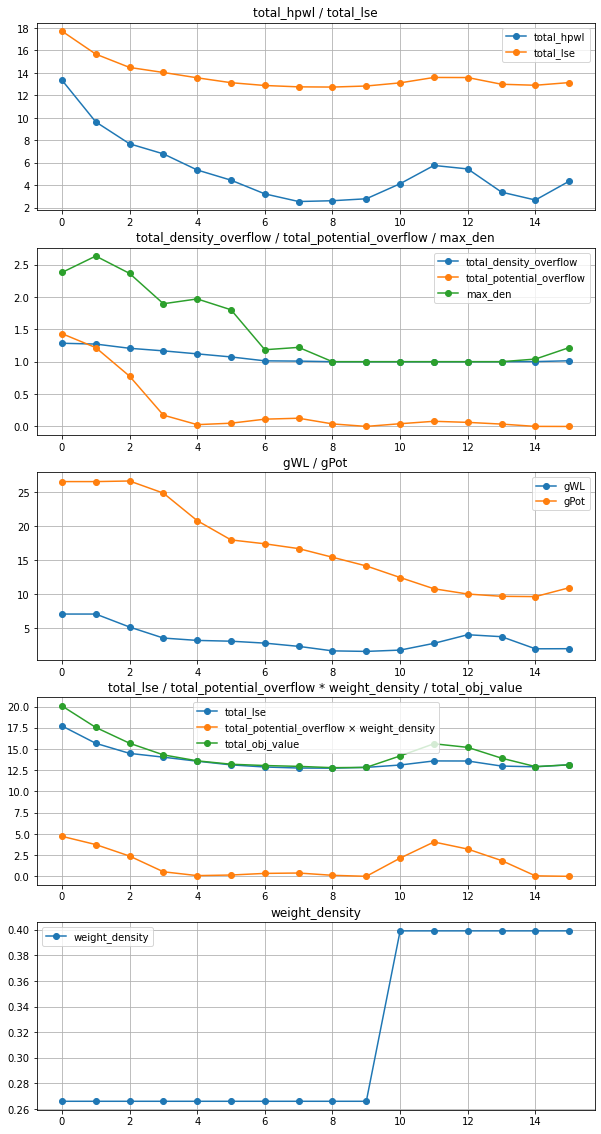

In [9]:
plot_cost_infos(cost_info_list)